In [1]:
!pip install -e ../.

Defaulting to user installation because normal site-packages is not writeable
Obtaining file:///Users/mayanknautiyal/Desktop/Codes/CVAEI
  Preparing metadata (setup.py) ... done
  Running setup.py develop for cvaei


In [2]:
import sys
sys.path.insert(0, '../')  # Adjust the path as necessary


In [3]:
import cvaei
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from torch import nn, optim
from cvaei.models.cvae_inference import CVAE
from cvaei.helper import DataNormalizer
from cvaei.visualize import scatter_plot_ma2
from cvaei.examples.MA2 import MovingAverage2
from cvaei.examples.two_moons import TwoMoons
from cvaei.examples.gk_dist import GKDistribution

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
print(torch.cuda.is_available())
print(torch.version.cuda)



Using device: cpu
False
None


In [4]:
gk_dist = GKDistribution()
train_theta_norm, train_data_norm, theta_normalizer, data_normalizer = gk_dist.prepare_data(100000)
observed_data = gk_dist.observed_data()
gk_dist.check_normalizer()

Normalization and denormalization process is consistent for both parameters and observed data.


In [6]:
train_theta_norm.shape, train_data_norm.shape

(torch.Size([100000, 4]), torch.Size([100000, 1000]))

# Initialise the Model

In [7]:
# ma2 = MovingAverage2()
# train_theta_norm, train_data_norm, theta_normalizer, data_normalizer = ma2.prepare_data(1000)
# observed_data = ma2.observed_data()
# print(ma2.check_normalizer())

# test = torch.tensor([3, 1, 2, 0.5], dtype = torch.float32)
# gk_dist.simulator(test)

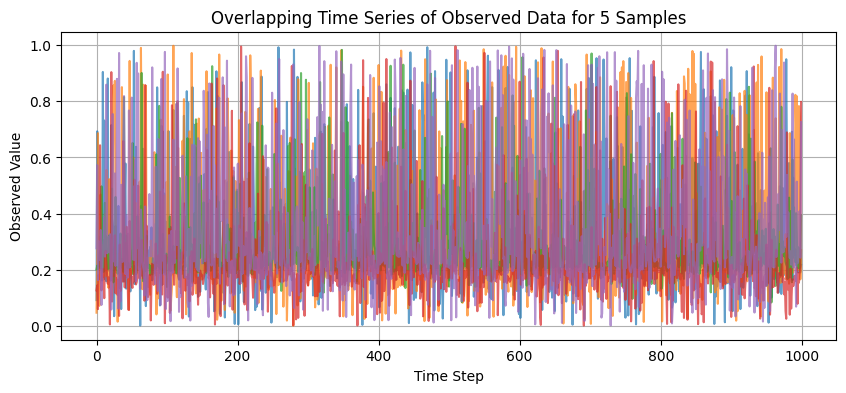

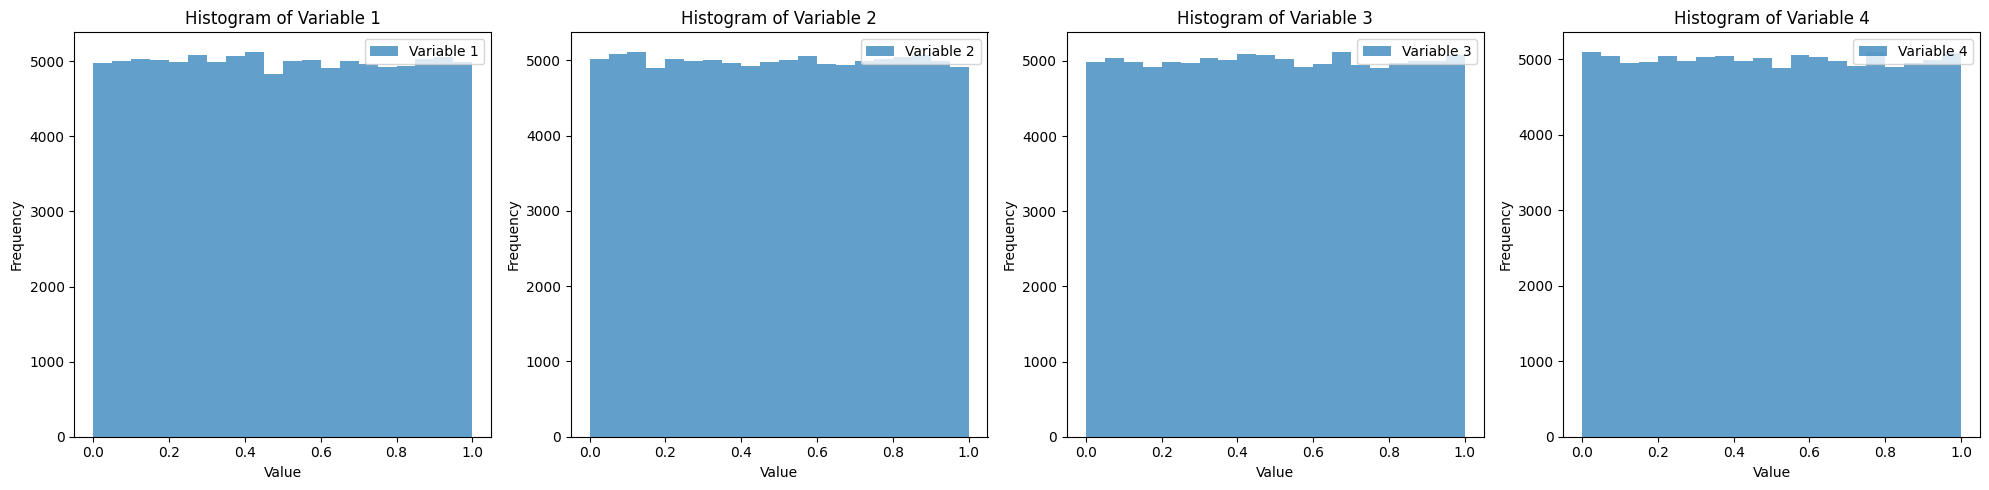

In [8]:
gk_dist.plot_observation(train_data_norm)
gk_dist.plot_prior(train_theta_norm)

# Define the CVAE Network

In [9]:
input_dim = 4
latent_dim = 20
conditional_dim = 1000
encoder_hidden_dims = [100]
decoder_hidden_dims = [2048,2048]
activation_fn = nn.LeakyReLU(0.1)

network = CVAE(input_dim=input_dim, 
               latent_dim=latent_dim, 
               output_dim=input_dim,
                conditional_dim=conditional_dim,
                encoder_hidden_dims=encoder_hidden_dims,
                decoder_hidden_dims=decoder_hidden_dims,
                activation_fn = activation_fn)


optimizer = optim.AdamW(network.parameters(), lr=1e-3)

train_dataset = TensorDataset(train_data_norm, train_theta_norm)
train_loader = DataLoader(dataset=train_dataset, batch_size=1024, shuffle=True)

print(network)

CVAE(
  (encoder): Encoder(
    (layers): Sequential(
      (0): Linear(in_features=4, out_features=100, bias=True)
      (1): LeakyReLU(negative_slope=0.1)
    )
    (fc_mean): Linear(in_features=100, out_features=20, bias=True)
    (fc_logvar): Linear(in_features=100, out_features=20, bias=True)
  )
  (decoder): Decoder(
    (layers): Sequential(
      (0): Linear(in_features=1020, out_features=2048, bias=True)
      (1): LeakyReLU(negative_slope=0.1)
      (2): Linear(in_features=2048, out_features=2048, bias=True)
      (3): LeakyReLU(negative_slope=0.1)
    )
    (final_layer): Linear(in_features=2048, out_features=4, bias=True)
  )
)


In [10]:
network.train_model(train_loader=train_loader, 
                    optimizer=optimizer,
                    epochs=2, 
                    device=device,
                    theta_normalizer=theta_normalizer,
                    data_normalizer=data_normalizer,
                    forward_model= gk_dist.simulator)

Using CPU
Epoch 1/2, Beta: 0.0, Total Loss: nan, Recon Loss: nan, Misfit Loss: nan, KL Div: nan
Epoch 2/2, Beta: 0.1, Total Loss: nan, Recon Loss: nan, Misfit Loss: nan, KL Div: nan


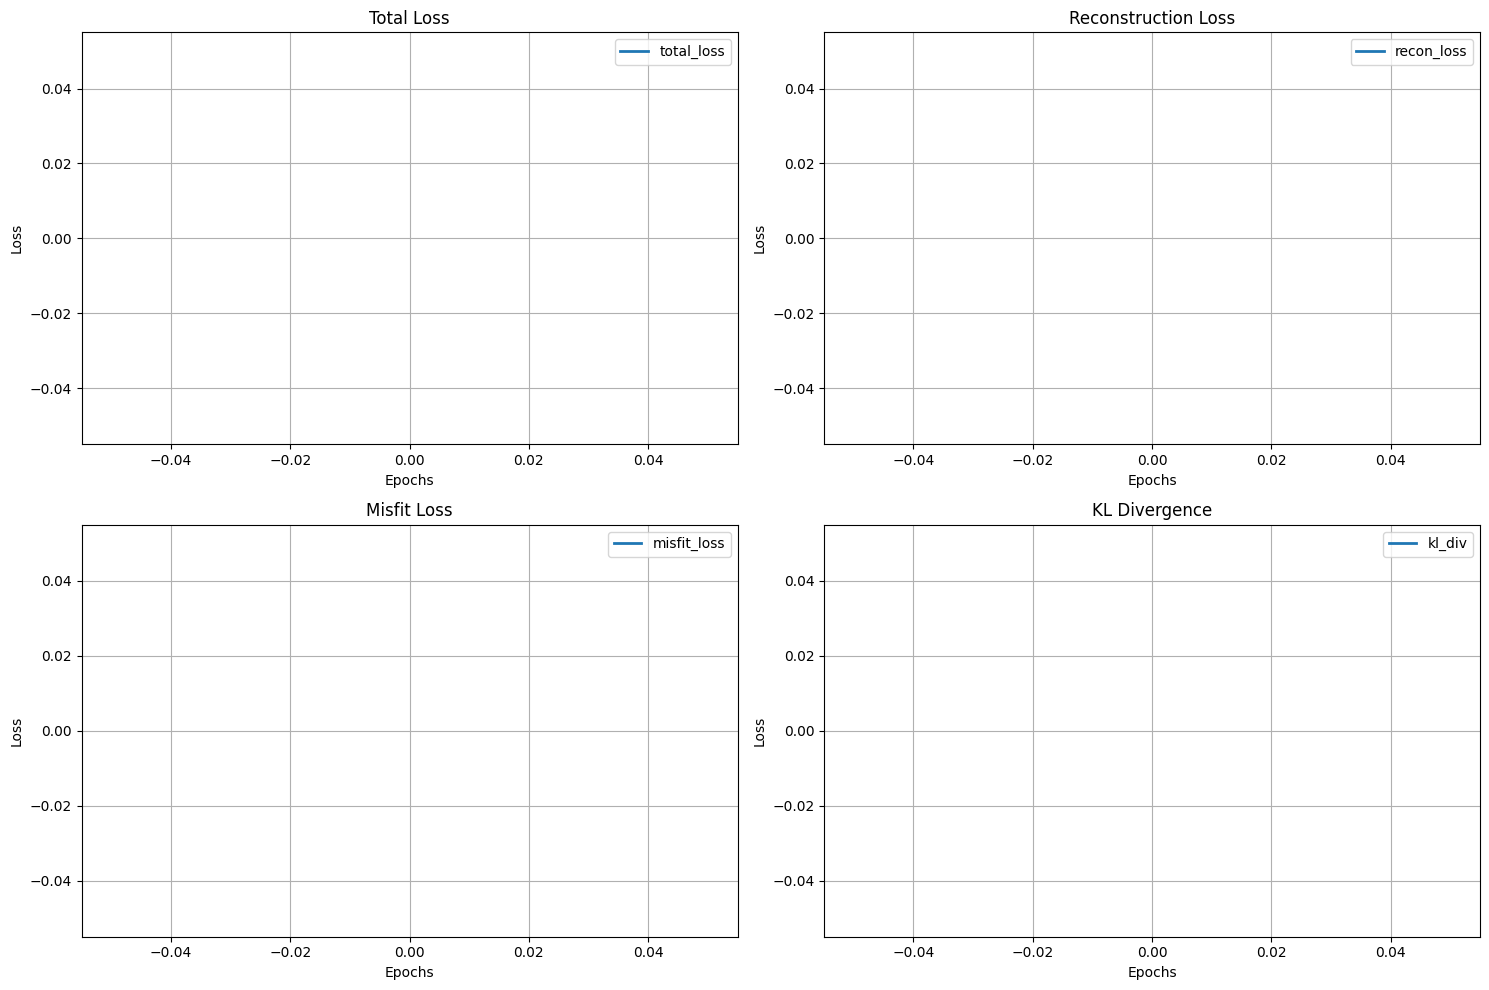

In [11]:
network.plot_loss()

# Inference

In [12]:
post = network.get_posterior(observed_data= observed_data, num_samples=1000)
post = theta_normalizer.inverse_transform(post)


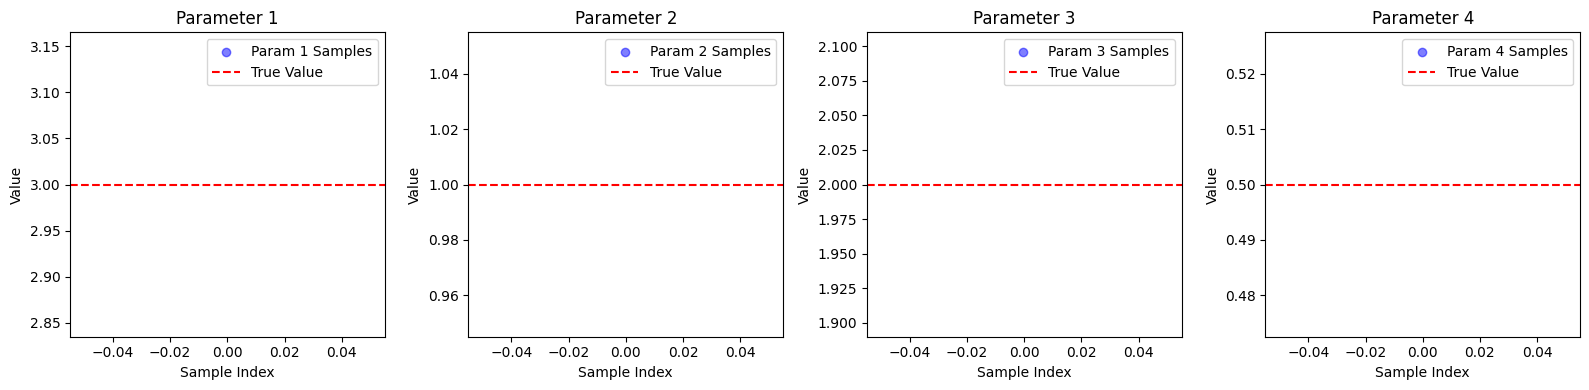

In [13]:
gk_dist.plot_posterior(post)

/Users/mayanknautiyal/Library/Python/3.9/lib/python/site-packages/matplotlib/axes/_axes.py:6762: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/Users/mayanknautiyal/Library/Python/3.9/lib/python/site-packages/matplotlib/axes/_axes.py:6763: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

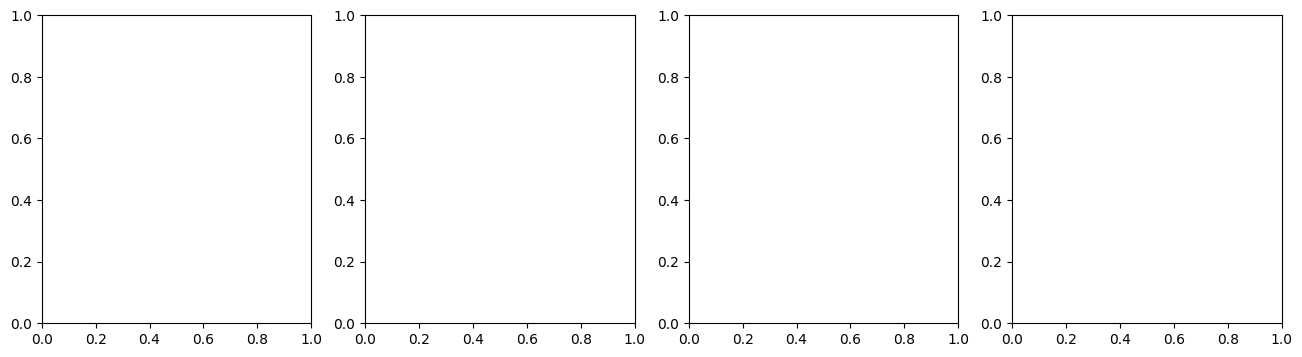

In [14]:
gk_dist.posterior_hist(post)